# ANN amb SHAP primera exploració

Ens centrem en:
- Importancia de les variables d'entrada en general. Estatiques o dinamiques? Quines són més importants tan a nivell de autoencoder i en general.
- Com actuen les variables en cada barri? Les veines? Si no hi ha prous registres per algun barri, podem fer poblenou sol comparat amb tots els barris junts.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import torch
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
torch.manual_seed(123)
np.random.seed(123)

In [3]:
from torch import nn as nn, Tensor

# ANN
class NeuralNetwork(nn.Module):
    def __init__(self, sequence):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = sequence

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out
    
arguments_assignment = {'section': 'pvector', 'pipeheight': 'pvector', 'pipewidth': 'pvector',
                        'perimeter': 'pvector', 'Length': 'pvector', 'Velocity': 'pvector',
                        'waterheight': 'pvector', 'flow': 'pvector', 'section_1': 'pvector', 'pipeheight_1': 'pvector',
                        'pipewidth_1': 'pvector', 'perimeter_1': 'pvector',
                        'Length_1': 'pvector', 'Velocity_1': 'pvector', 'waterheight_1': 'pvector', 'flow_1': 'pvector',
                        'section_2': 'pvector',
                        'pipeheight_2': 'pvector', 'pipewidth_2': 'pvector', 'perimeter_2': 'pvector',
                        'Length_2': 'pvector', 'Velocity_2': 'pvector',
                        'waterheight_2': 'pvector', 'flow_2': 'pvector', 'section_3': 'pvector',
                        'pipeheight_3': 'pvector', 'pipewidth_3': 'pvector',
                        'perimeter_3': 'pvector', 'Length_3': 'pvector', 'Velocity_3': 'pvector',
                        'waterheight_3': 'pvector', 'flow_3': 'pvector',
                        'section_4': 'pvector', 'pipeheight_4': 'pvector', 'pipewidth_4': 'pvector',
                        'perimeter_4': 'pvector', 'Length_4': 'pvector',
                        'Velocity_4': 'pvector', 'waterheight_4': 'pvector', 'flow_4': 'pvector',
                        'section_5': 'pvector', 'pipeheight_5': 'pvector',
                        'pipewidth_5': 'pvector', 'perimeter_5': 'pvector', 'Length_5': 'pvector',
                        'Velocity_5': 'pvector', 'waterheight_5': 'pvector',
                        'flow_5': 'pvector', 'neighbourhood': 'pvector', 'amount_rain_mean': 'dvector',
                        'amount_rain_std': 'dvector', 'value_0': 'dvector', 'value_1': 'dvector',
                        'cleaning_applied_0': 'dvector', 'cleaning_applied_1': 'dvector',
                        'amount_rain_mean_1': 'dvector',
                        'amount_rain_std_1': 'dvector', 'value_0_1': 'dvector', 'value_1_1': 'dvector',
                        'cleaning_applied_0_1': 'dvector',
                        'cleaning_applied_1_1': 'dvector', 'amount_rain_mean_2': 'dvector',
                        'amount_rain_std_2': 'dvector',
                        'value_0_2': 'dvector', 'value_1_2': 'dvector', 'cleaning_applied_0_2': 'dvector',
                        'cleaning_applied_1_2': 'dvector', 'amount_rain_mean_3': 'dvector',
                        'amount_rain_std_3': 'dvector',
                        'value_0_3': 'dvector', 'value_1_3': 'dvector', 'cleaning_applied_0_3': 'dvector',
                        'cleaning_applied_1_3': 'dvector', 'amount_rain_mean_4': 'dvector',
                        'amount_rain_std_4': 'dvector',
                        'value_0_4': 'dvector', 'value_1_4': 'dvector', 'cleaning_applied_0_4': 'dvector',
                        'cleaning_applied_1_4': 'dvector', 'amount_rain_mean_5': 'dvector',
                        'amount_rain_std_5': 'dvector',
                        'value_0_5': 'dvector', 'value_1_5': 'dvector', 'cleaning_applied_0_5': 'dvector',
                        'cleaning_applied_1_5': 'dvector'}

In [4]:
def load_model(model, path):
    # Load the saved model state dict
    model.load_state_dict(torch.load(path))

    # Set the model to evaluation mode
    model.eval()

    return model

In [5]:
sequence = nn.Sequential(nn.Linear(46, 20), nn.Softsign(), nn.Linear(20, 20), nn.Softsign(), nn.Linear(20, 1),
                         nn.Sigmoid())
ann5 = NeuralNetwork(sequence)
ann10 = NeuralNetwork(sequence)
ann15 = NeuralNetwork(sequence)
ann20 = NeuralNetwork(sequence)

path_ann5 = '../../../models/model_threshold_5'
path_ann10='../../../models/model_threshold_10'
path_ann15='../../../models/model_threshold_15'
path_ann20='../../../models/model_threshold_20'

ann5 = load_model(ann5, path_ann5)
ann10 = load_model(ann10, path_ann10)
ann15 = load_model(ann15, path_ann15)
ann20 = load_model(ann20, path_ann20)

In [6]:
anndata = pd.read_csv('../../../data/final/anndata.csv', index_col=0)

In [7]:
anndata = anndata.drop(['value_2'], axis=1)

In [8]:
anntrain = torch.tensor(anndata.iloc[:int(len(anndata) * 0.8)].values.tolist(), dtype=torch.float32)
anntest = torch.tensor(anndata.iloc[int(len(anndata) * 0.8):].values.tolist(), dtype=torch.float32)
X = torch.tensor(anndata.values.tolist(), dtype=torch.float32)
x = torch.tensor(anndata.iloc[int(len(anndata) * 0.6):].values.tolist(), dtype=torch.float32)

## We start by ANN with 5% threshold prediction

In [9]:
explainer = shap.DeepExplainer(ann5, X)

# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [10]:
explanation = shap.Explanation(values=shap_values, 
                               base_values=explainer.expected_value, 
                               feature_names=anndata.columns.tolist())

In [11]:
shap.initjs()

In [12]:
feature_names = anndata.columns

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


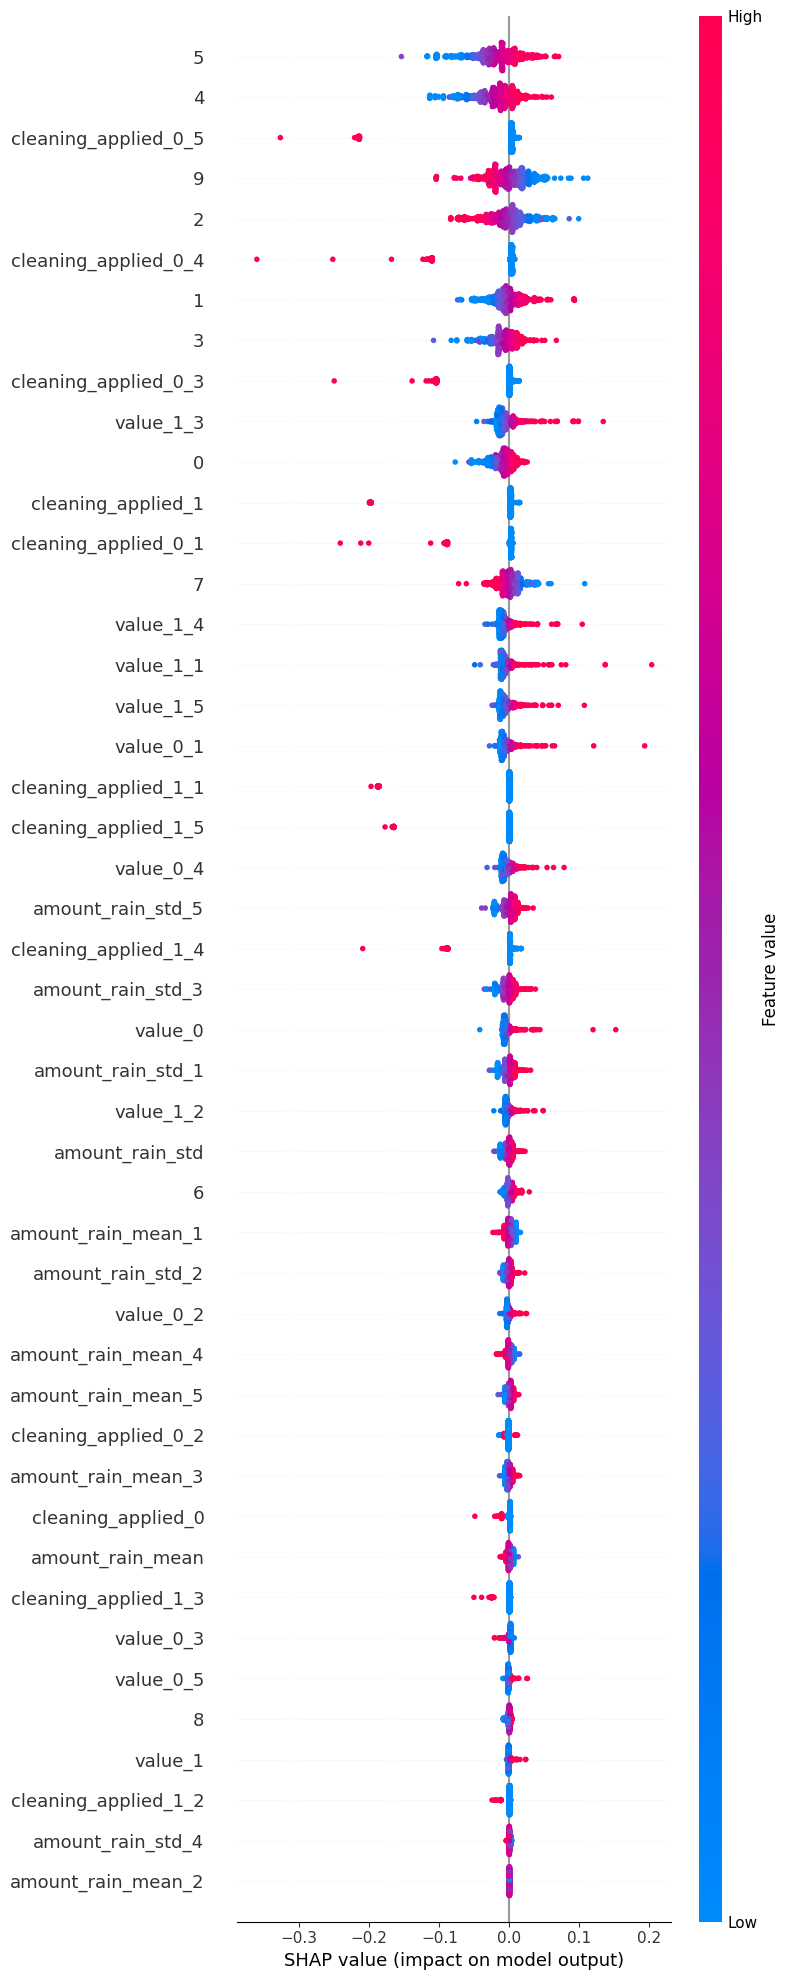

In [13]:
# Create a summary plot
shap.summary_plot(shap_values, features=x, feature_names=feature_names, show=False, max_display=50)

plt.show()

- Cleanings of neighbour pipes have a negative impact on the model when the values are high. Check what happens with individual cleanings.
- Interesting variables from the autoencoder: **5, 10, 12, 2**. Check how they affect and which have more impact on them in the AE.
- Value_0 vs Value_Neighbours. Differences?

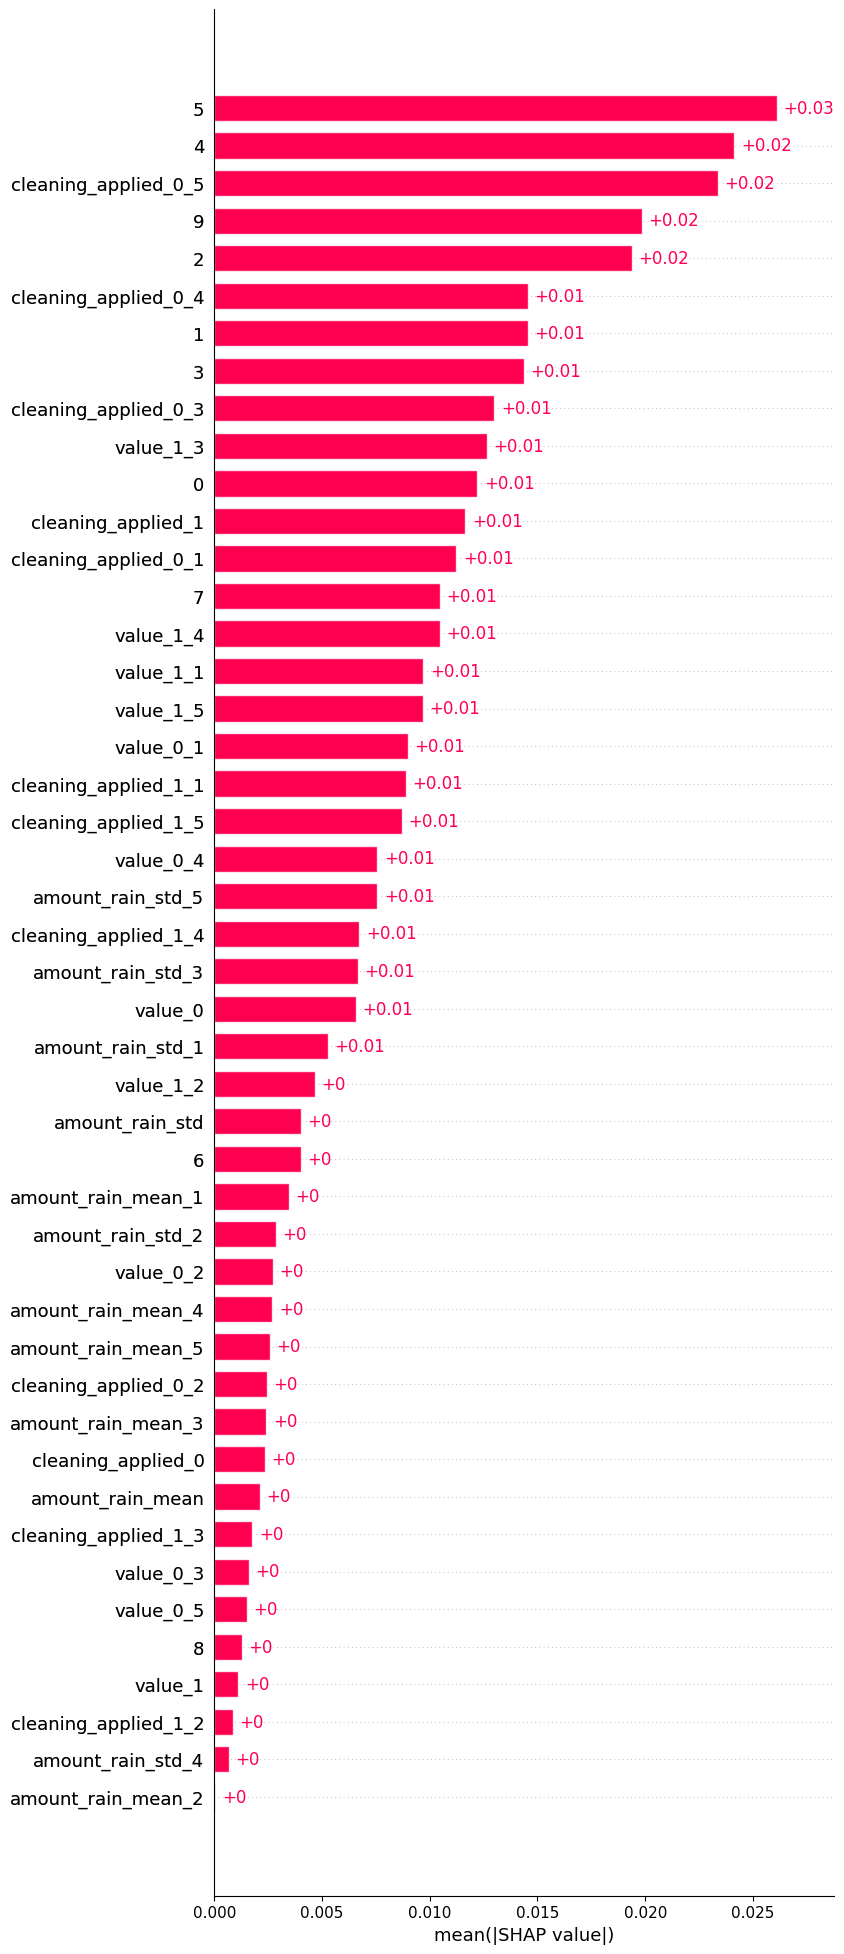

In [14]:
shap.plots.bar(explanation, max_display=50)
plt.show()

Not much impact from the different features. There's no relevant feature overall, all of them have a relatively low contribution.

## Individual feature explanation

### Checking individual cleanings

In [15]:
import json

def print_strings_as_json(strings):
    data = []
    for i, string in enumerate(strings):
        data.append({"position": i, "string": string})

    json_data = json.dumps(data, indent=4)
    print(json_data)

In [16]:
print_strings_as_json(feature_names)

[
    {
        "position": 0,
        "string": "amount_rain_mean"
    },
    {
        "position": 1,
        "string": "amount_rain_std"
    },
    {
        "position": 2,
        "string": "value_0"
    },
    {
        "position": 3,
        "string": "value_1"
    },
    {
        "position": 4,
        "string": "cleaning_applied_0"
    },
    {
        "position": 5,
        "string": "cleaning_applied_1"
    },
    {
        "position": 6,
        "string": "amount_rain_mean_1"
    },
    {
        "position": 7,
        "string": "amount_rain_std_1"
    },
    {
        "position": 8,
        "string": "value_0_1"
    },
    {
        "position": 9,
        "string": "value_1_1"
    },
    {
        "position": 10,
        "string": "cleaning_applied_0_1"
    },
    {
        "position": 11,
        "string": "cleaning_applied_1_1"
    },
    {
        "position": 12,
        "string": "amount_rain_mean_2"
    },
    {
        "position": 13,
        "string": "amount_rain_s

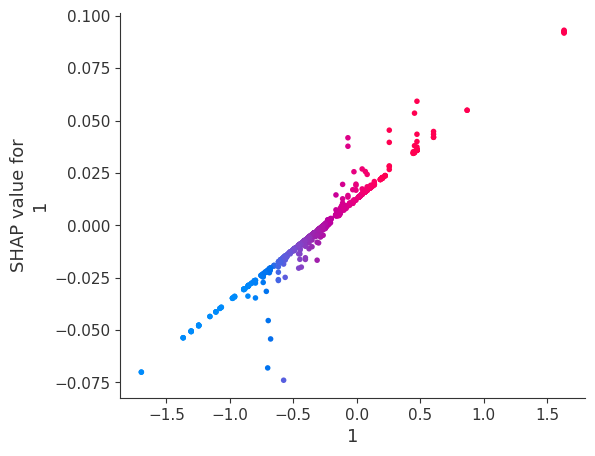

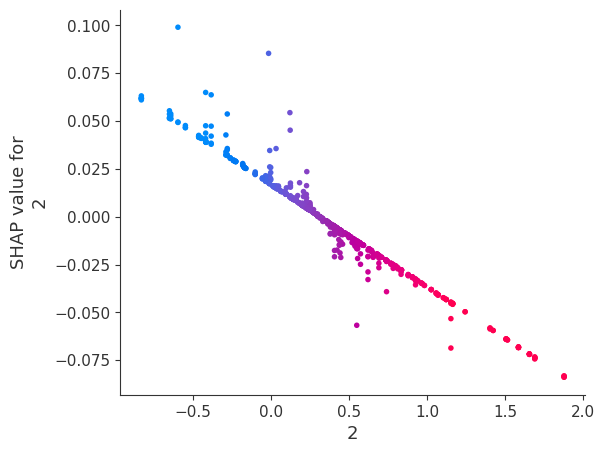

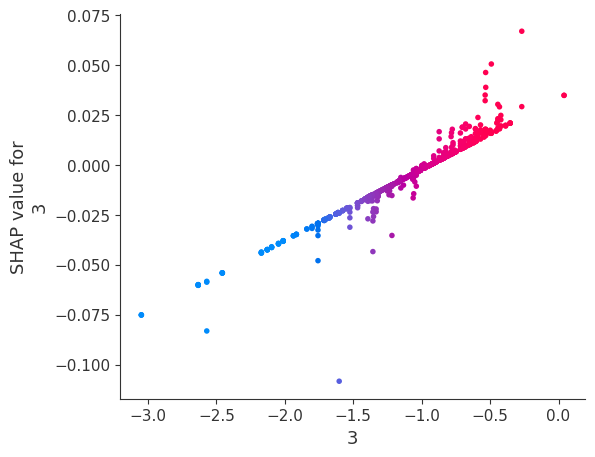

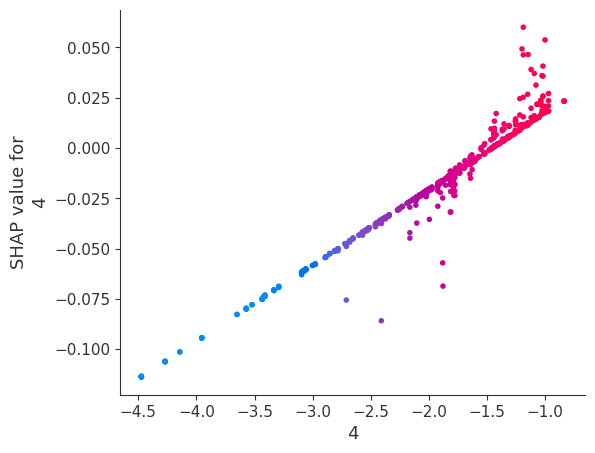

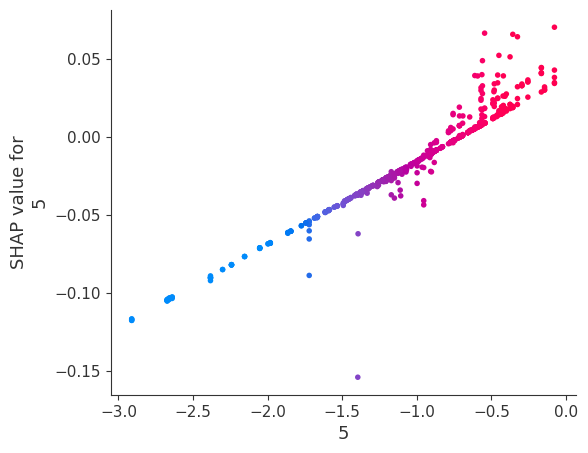

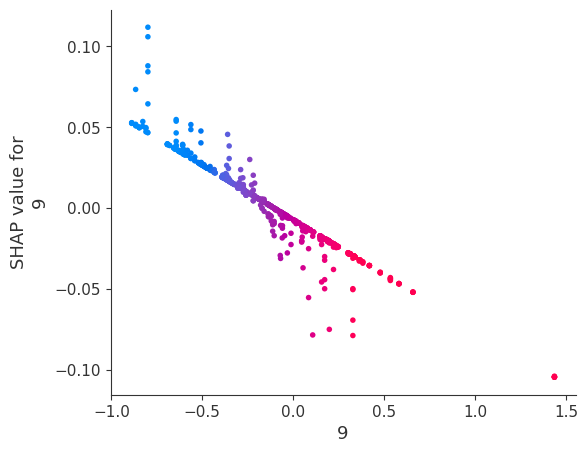

In [17]:
for feature_index in [37, 38, 39, 40, 41, 45]:
    shap.dependence_plot(feature_index, shap_values, x.numpy(), feature_names= feature_names, interaction_index=feature_index)

    plt.show()

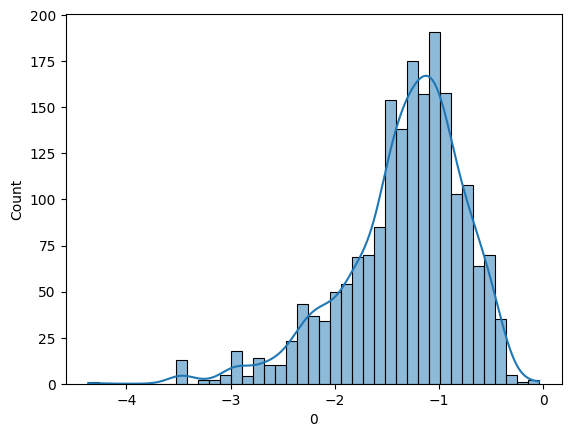

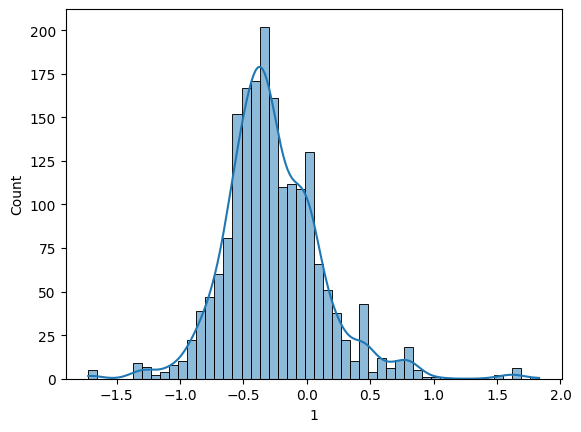

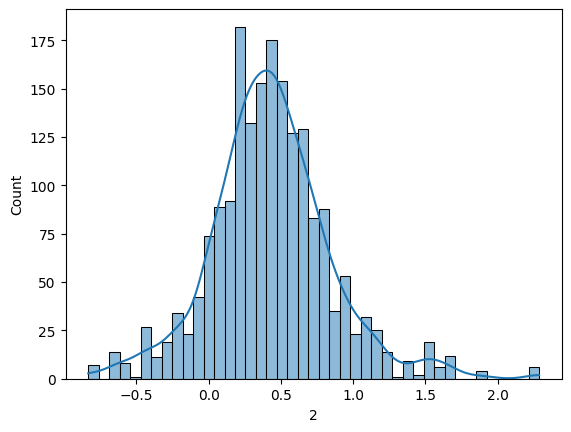

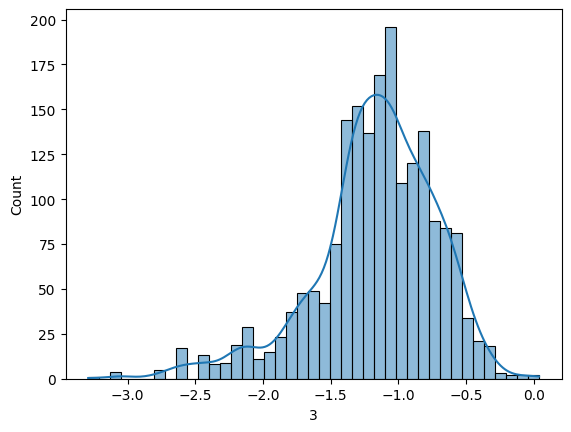

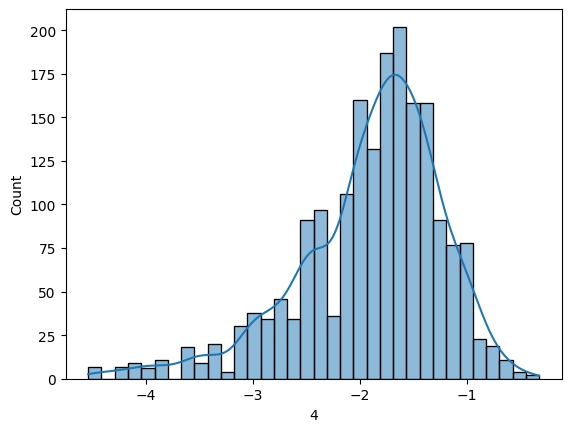

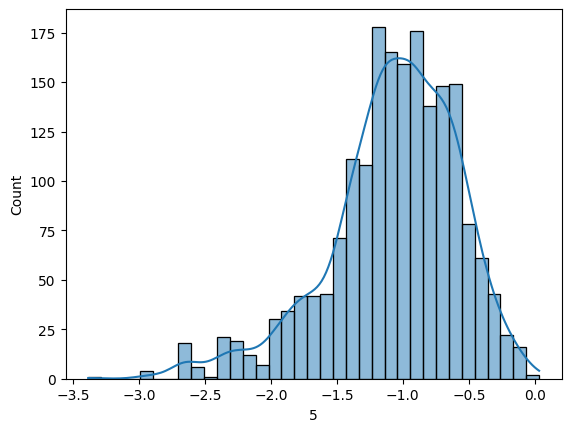

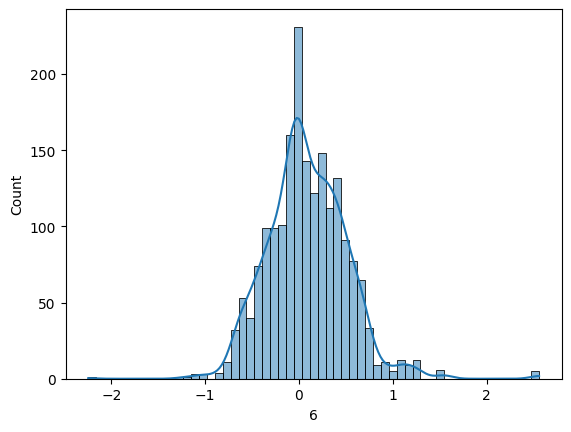

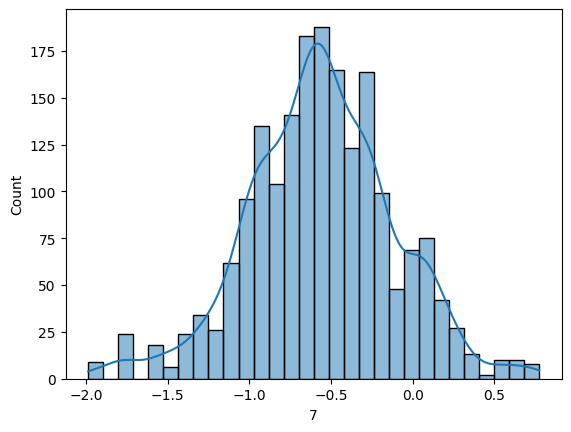

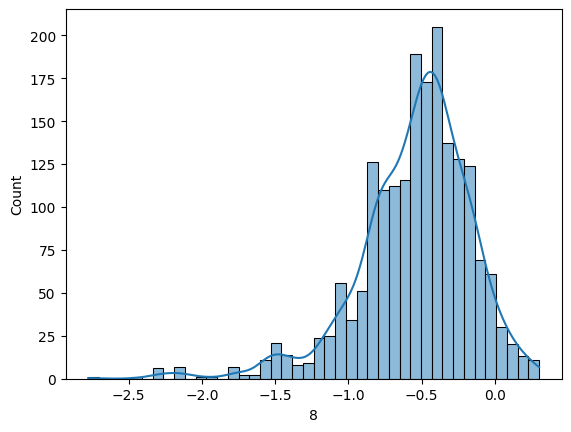

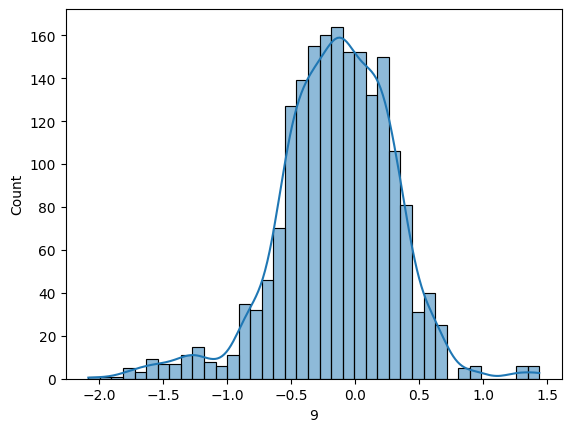

In [19]:
for i in range(36, len(anndata.columns)):
    sns.histplot(data=anndata.iloc[:, i], kde=True)
    plt.show()

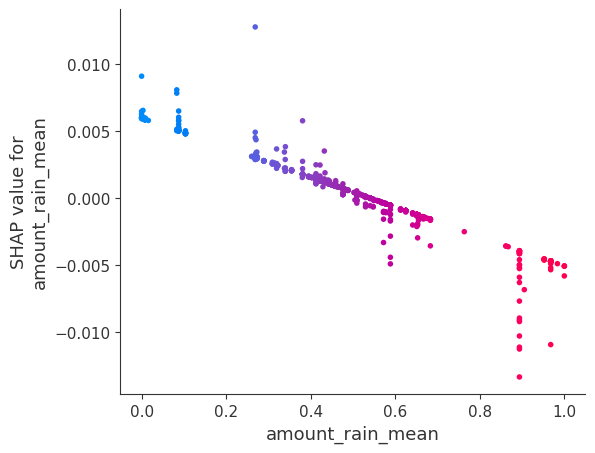

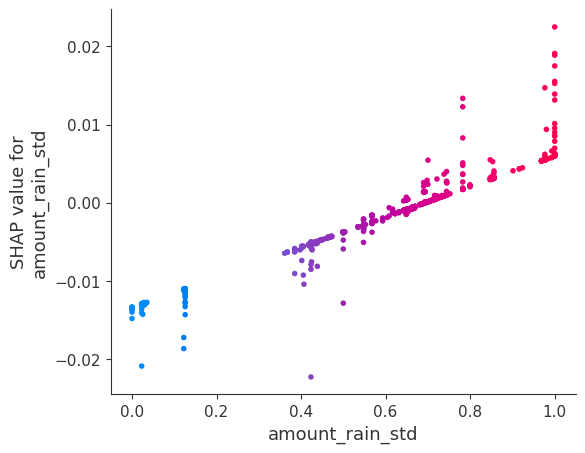

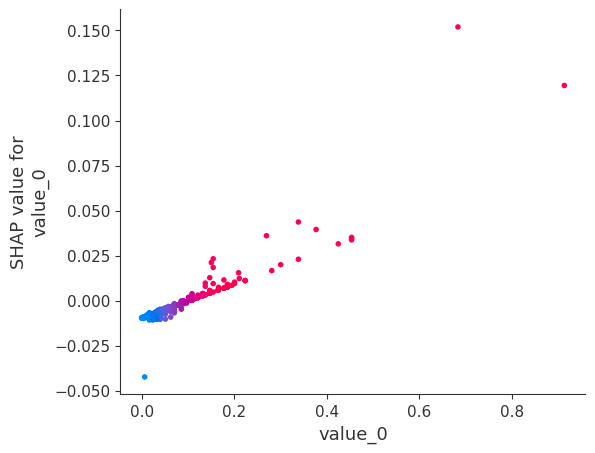

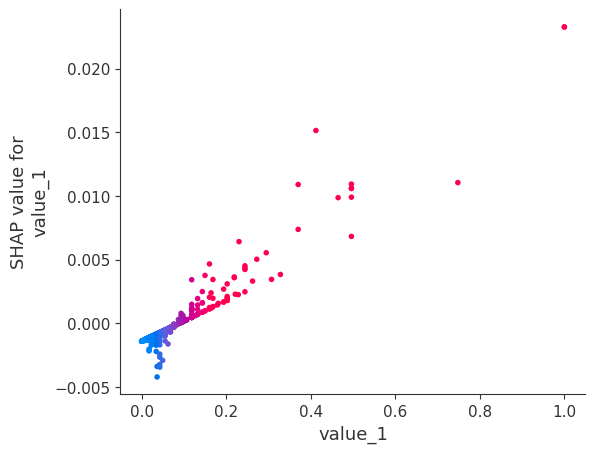

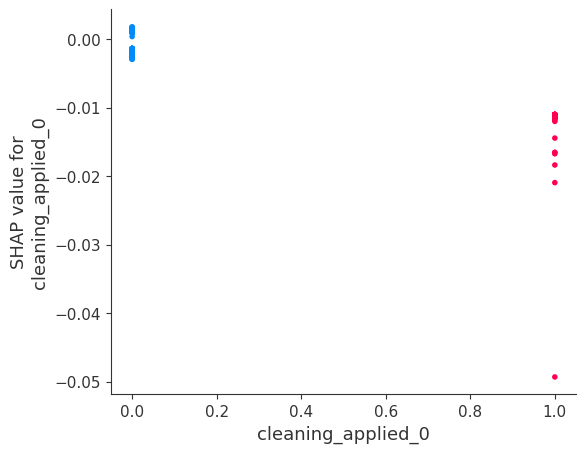

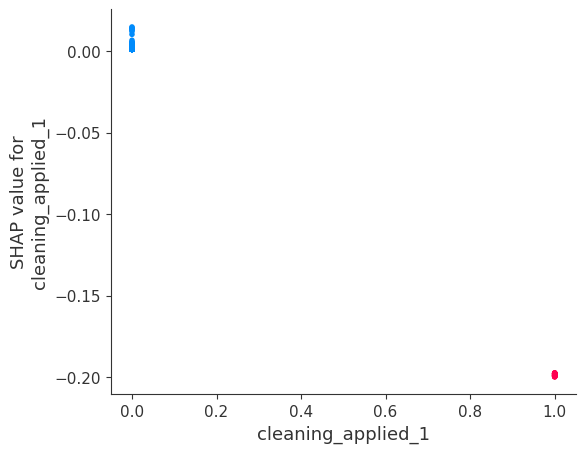

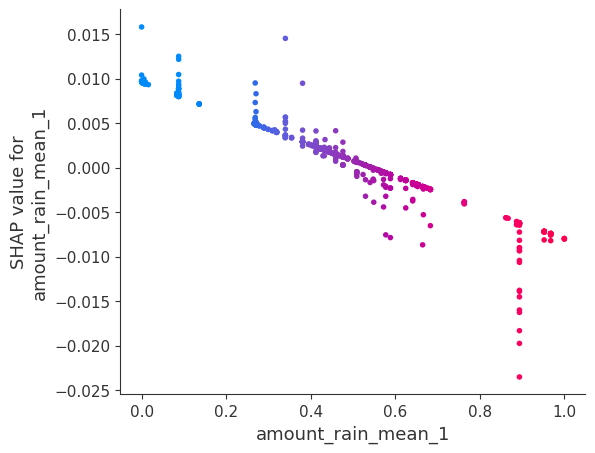

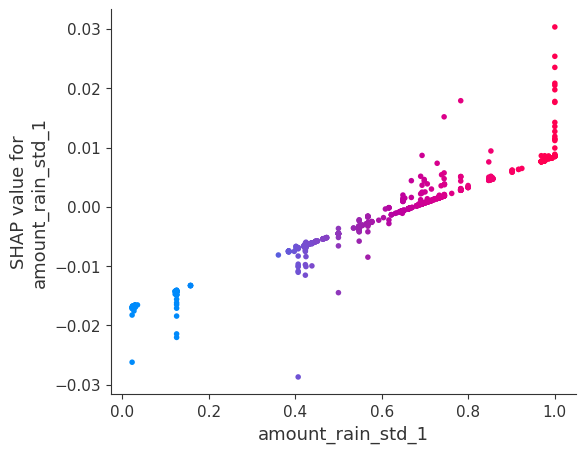

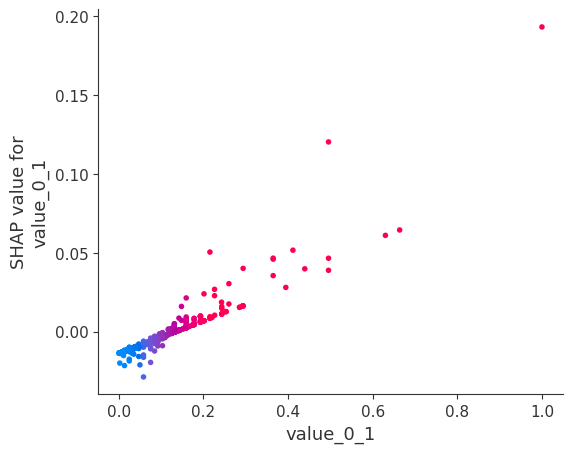

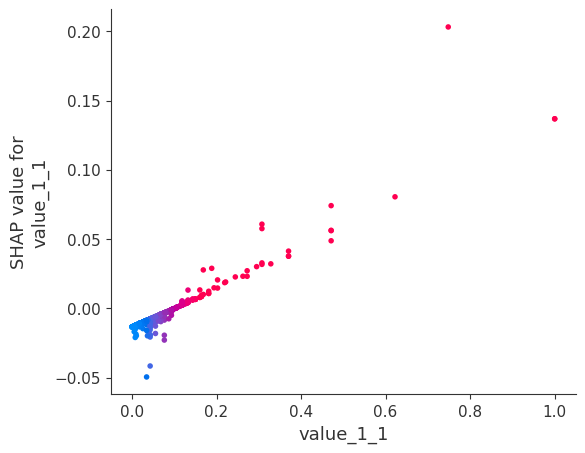

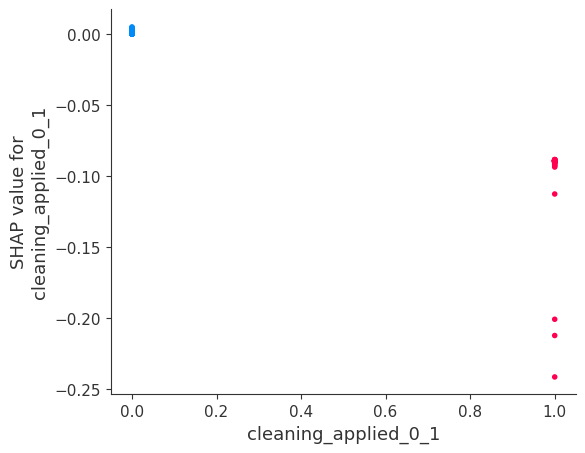

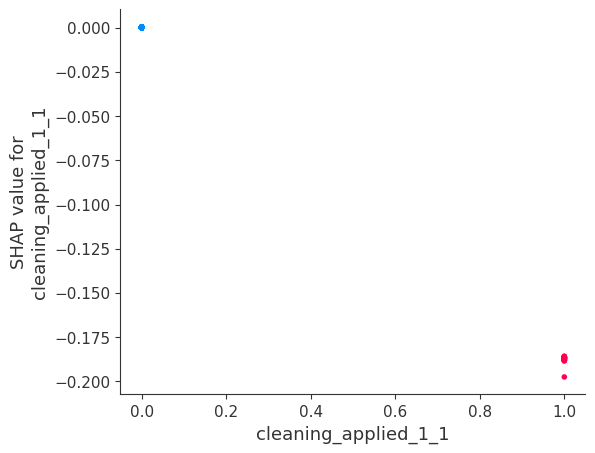

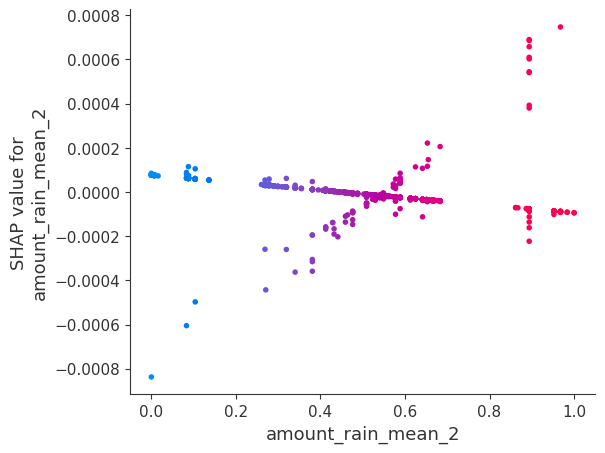

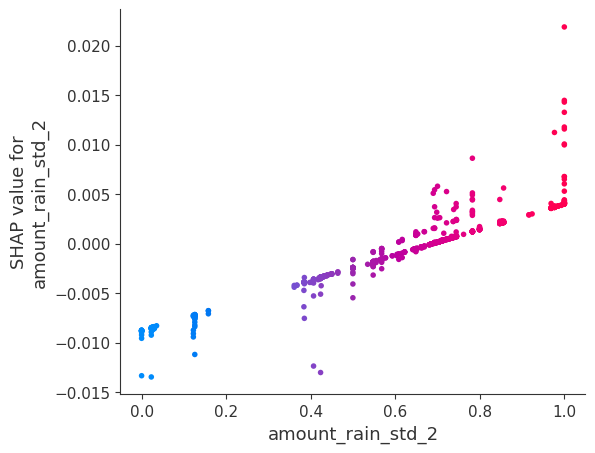

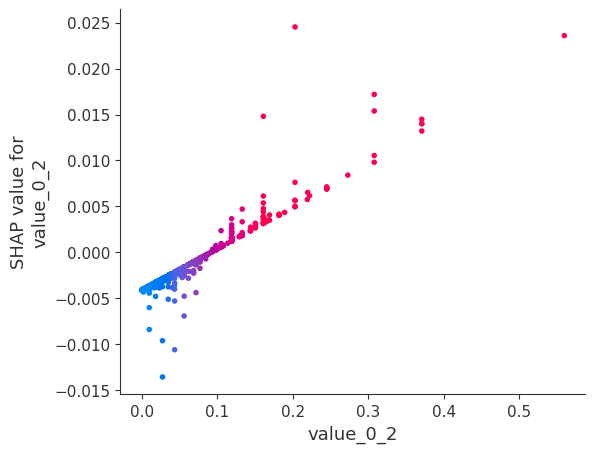

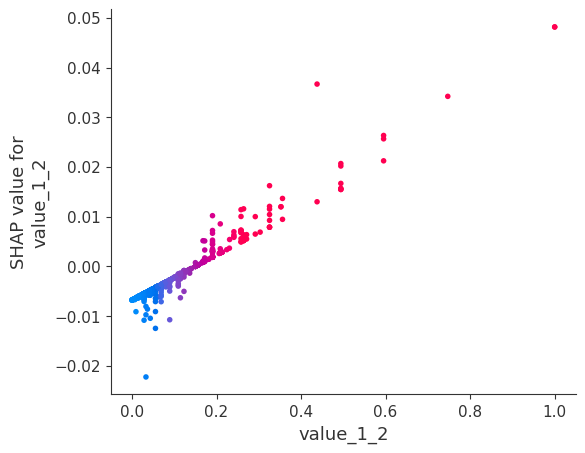

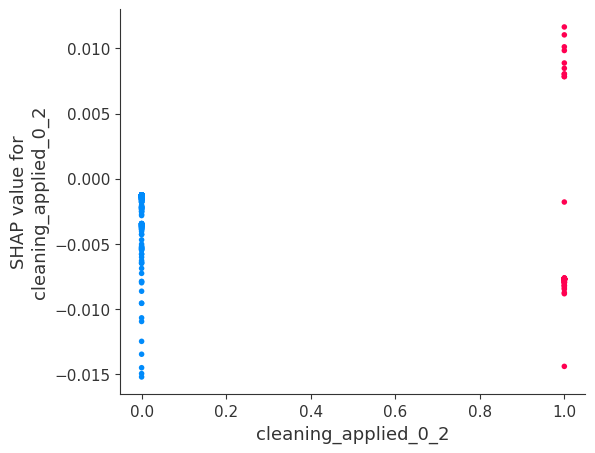

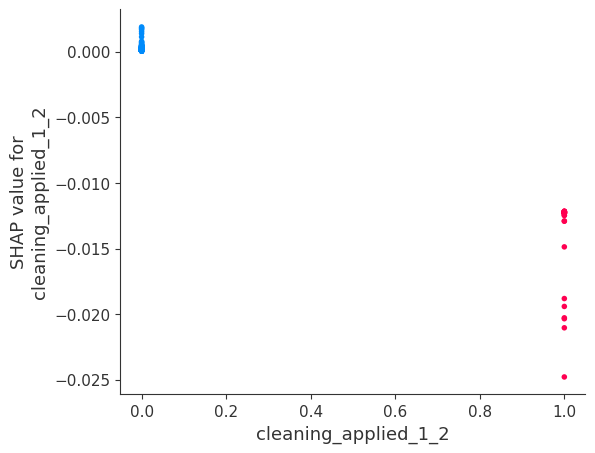

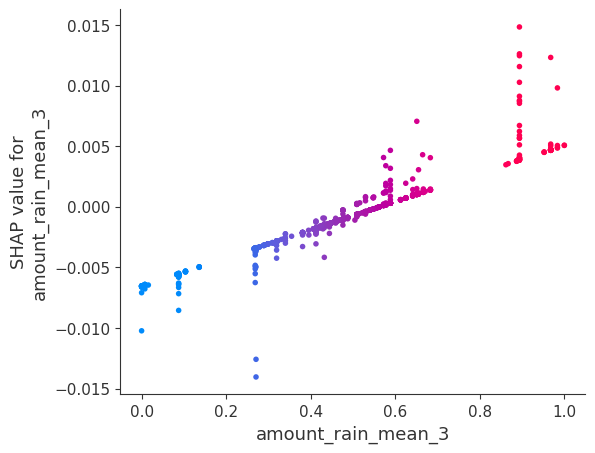

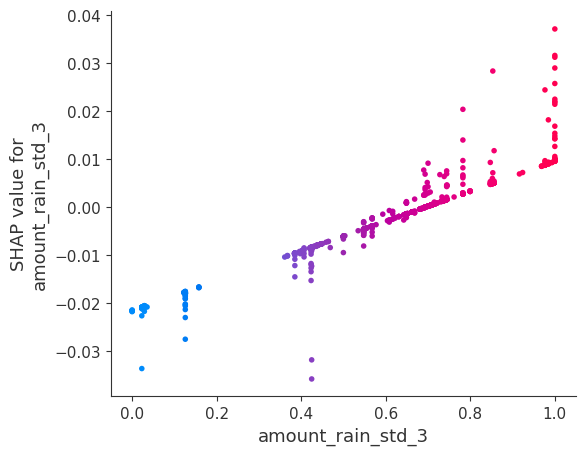

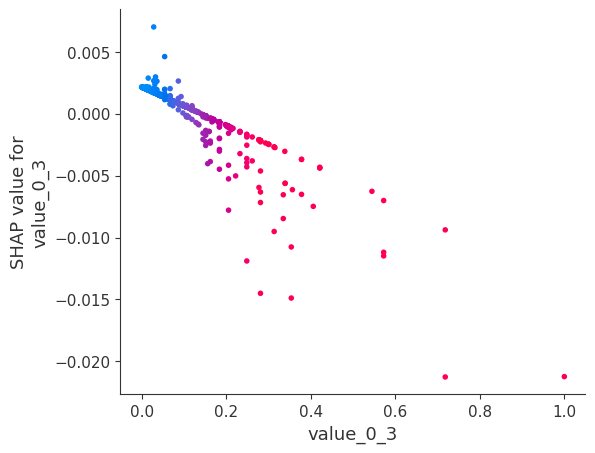

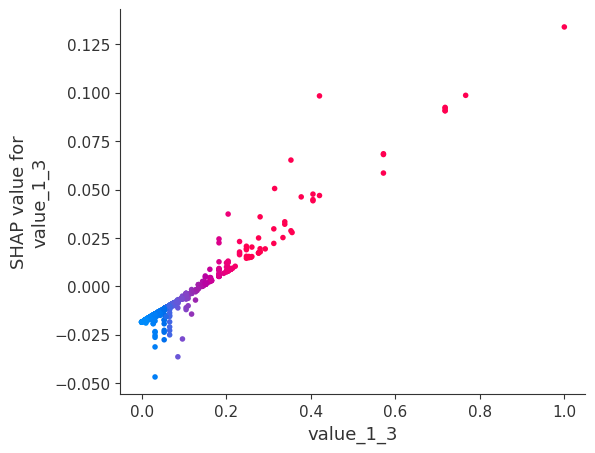

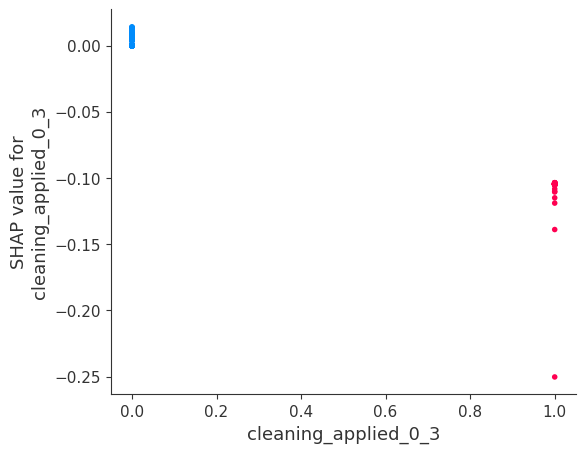

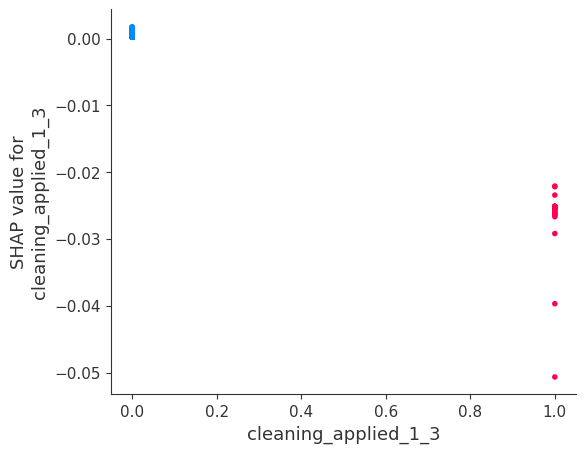

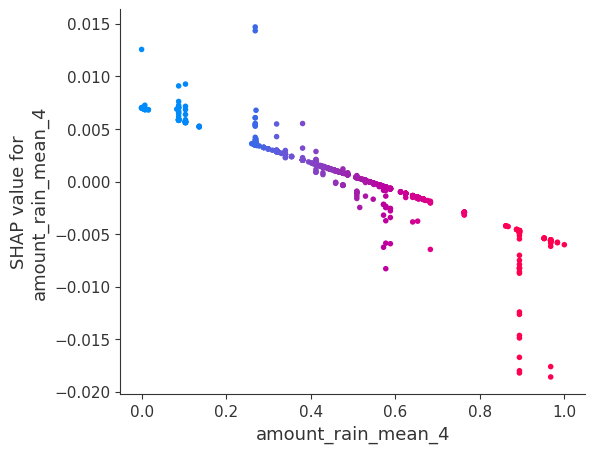

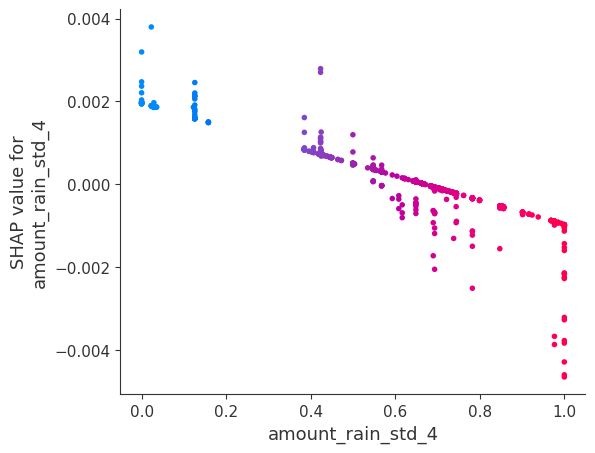

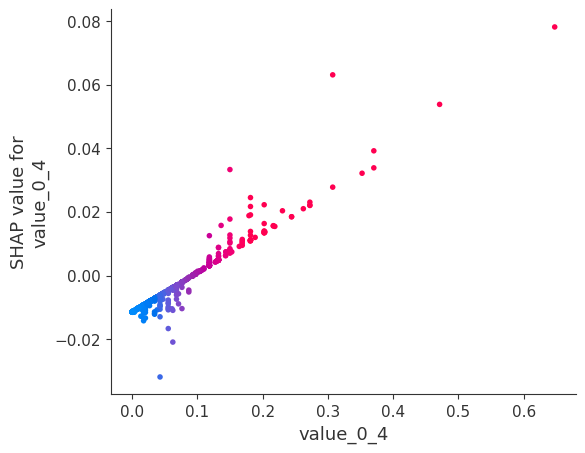

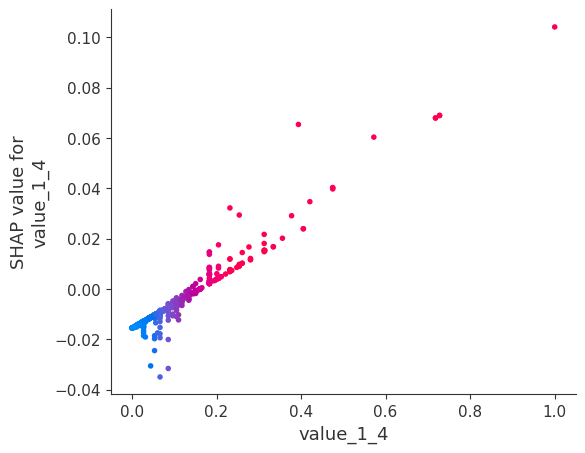

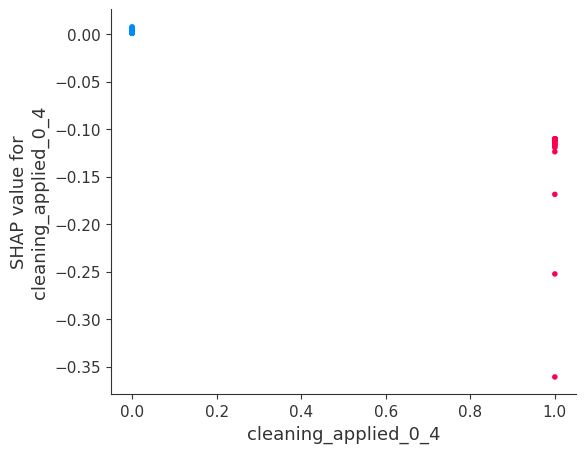

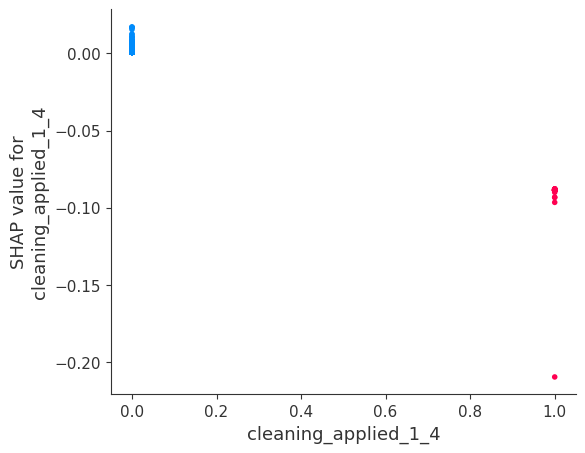

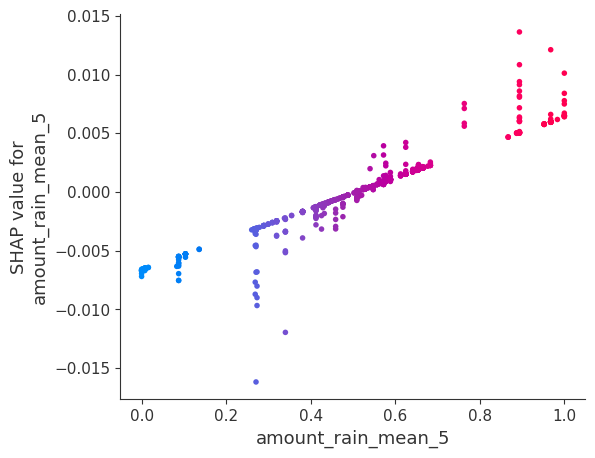

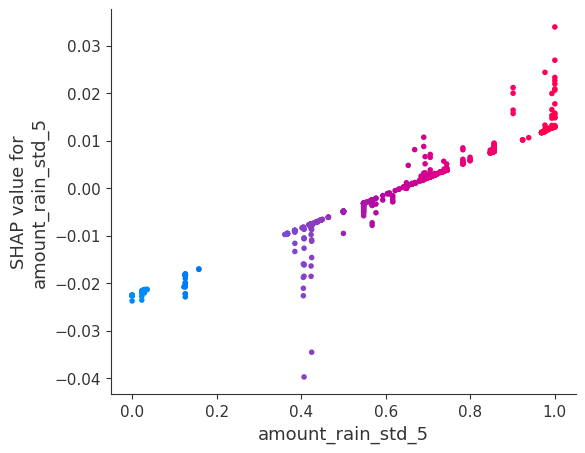

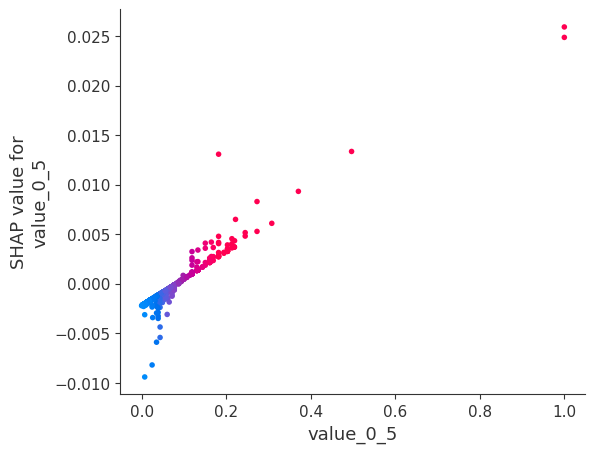

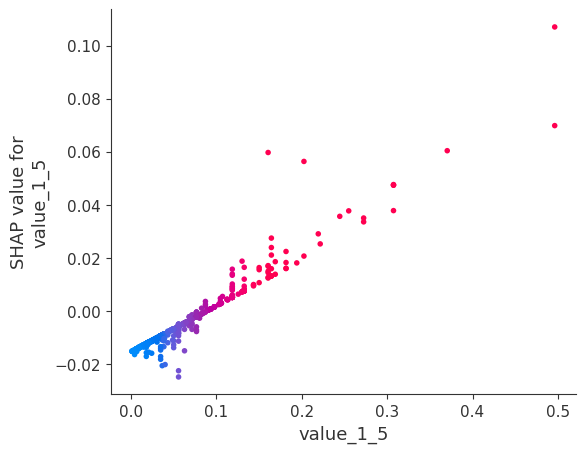

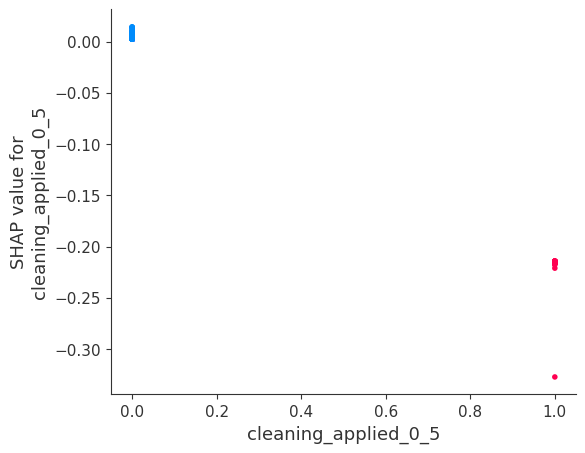

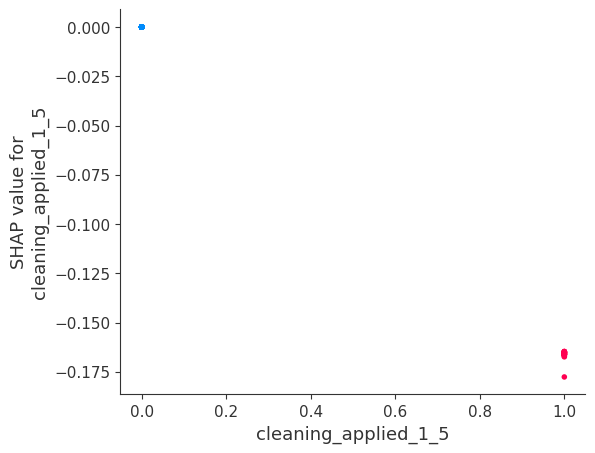

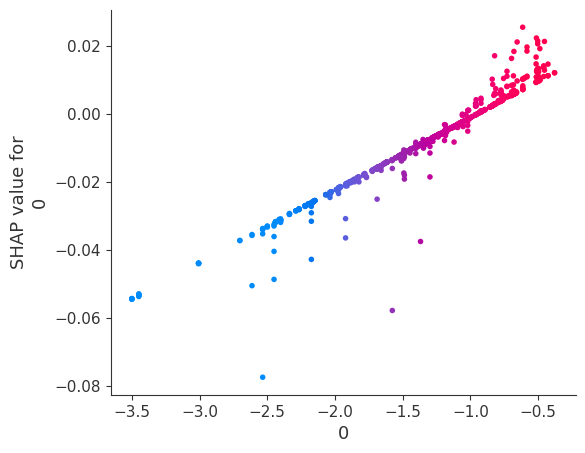

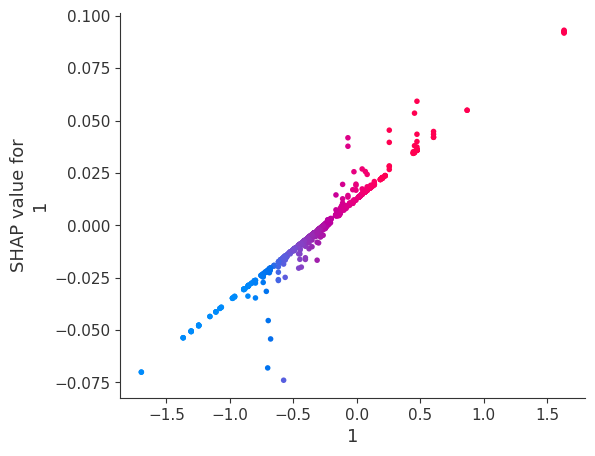

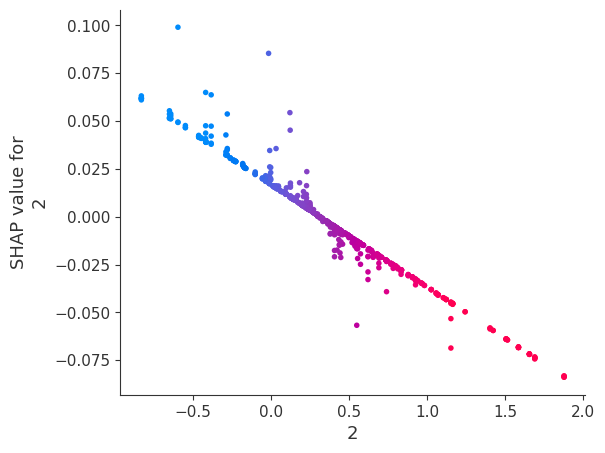

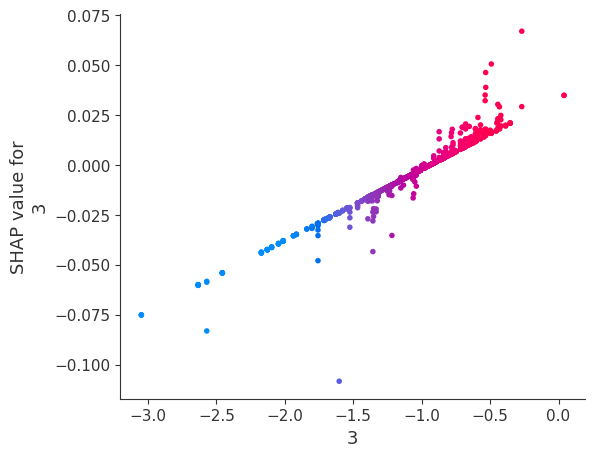

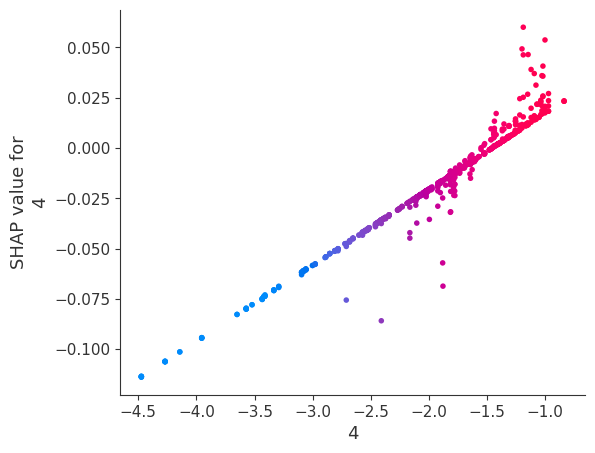

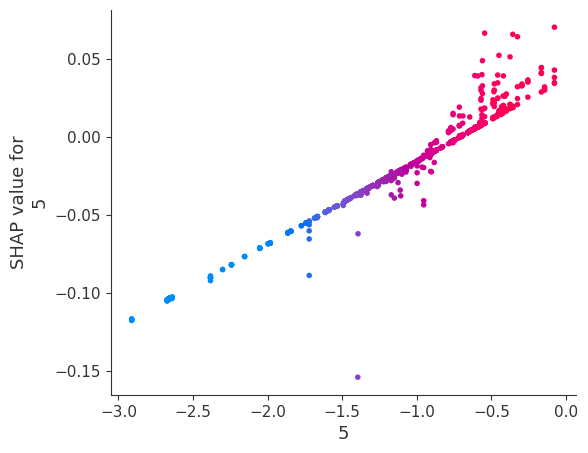

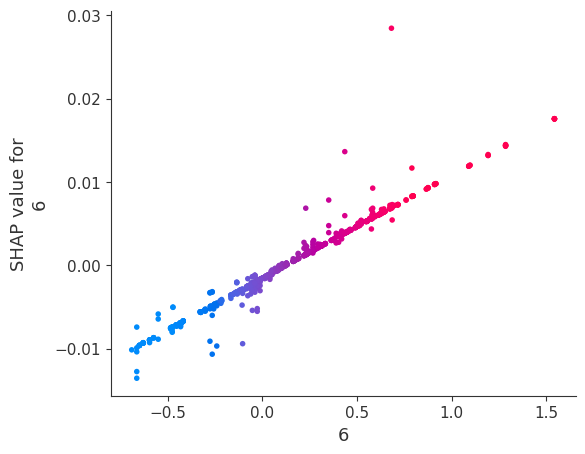

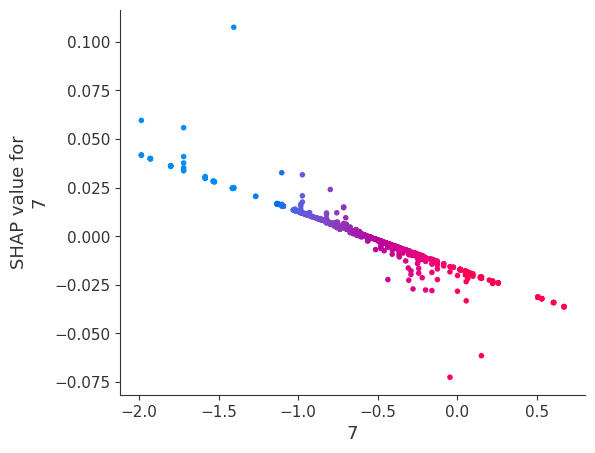

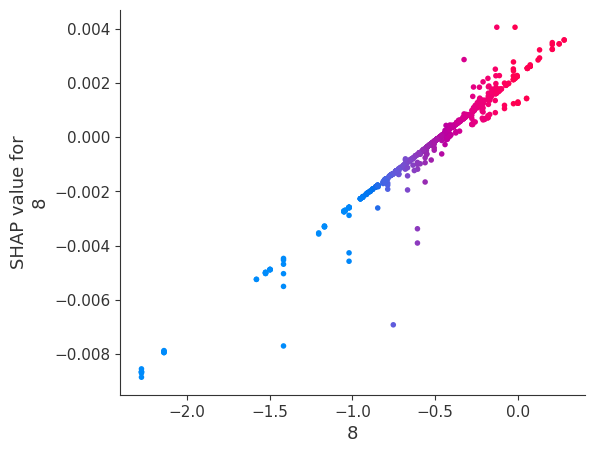

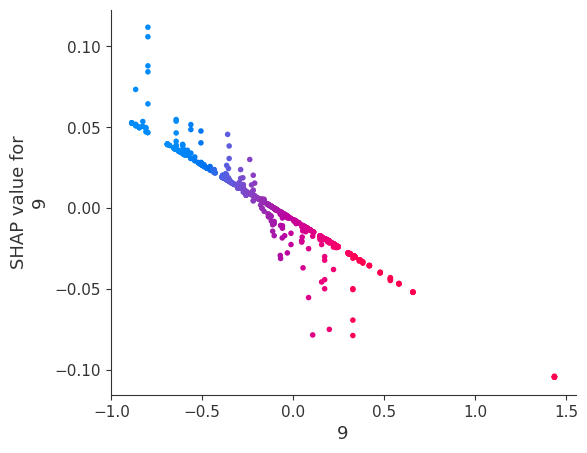

In [20]:
for feature_index in range(len(feature_names)):
    shap.dependence_plot(feature_index, shap_values, x.numpy(), feature_names= feature_names, interaction_index=feature_index)

    plt.show()

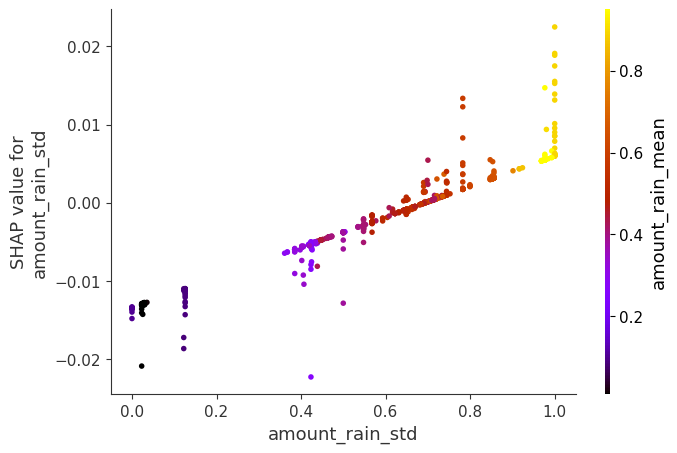

In [22]:
shap.dependence_plot(1, shap_values, x.numpy(), feature_names= feature_names, interaction_index=0, cmap='gnuplot')
plt.show()

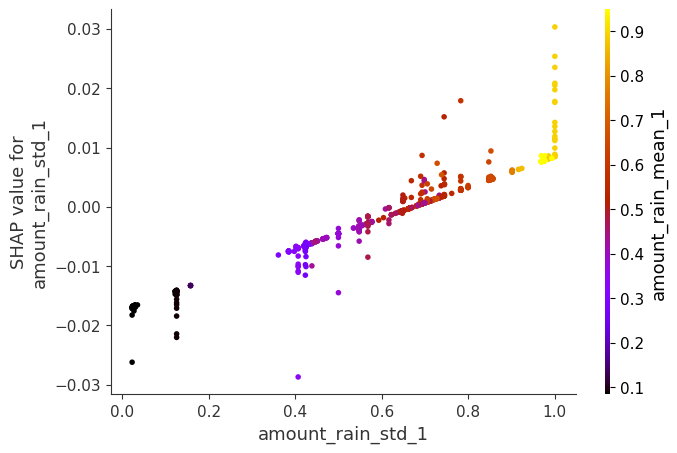

In [37]:
shap.dependence_plot(7, shap_values, x.numpy(), feature_names= feature_names, interaction_index=6, cmap='gnuplot')
plt.show()

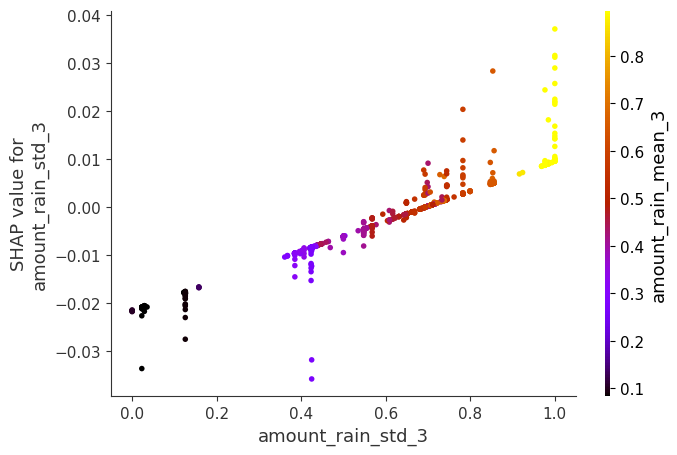

In [38]:
shap.dependence_plot(19, shap_values, x.numpy(), feature_names= feature_names, interaction_index=18, cmap='gnuplot')
plt.show()

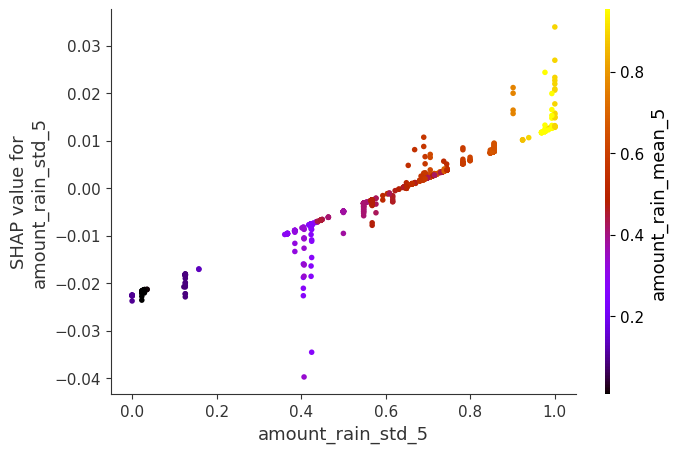

In [39]:
shap.dependence_plot(31, shap_values, x.numpy(), feature_names= feature_names, interaction_index=30, cmap='gnuplot')
plt.show()

In [56]:
anndata.columns

Index(['amount_rain_mean', 'amount_rain_std', 'value_0', 'value_1',
       'cleaning_applied_0', 'cleaning_applied_1', 'amount_rain_mean_1',
       'amount_rain_std_1', 'value_0_1', 'value_1_1', 'cleaning_applied_0_1',
       'cleaning_applied_1_1', 'amount_rain_mean_2', 'amount_rain_std_2',
       'value_0_2', 'value_1_2', 'cleaning_applied_0_2',
       'cleaning_applied_1_2', 'amount_rain_mean_3', 'amount_rain_std_3',
       'value_0_3', 'value_1_3', 'cleaning_applied_0_3',
       'cleaning_applied_1_3', 'amount_rain_mean_4', 'amount_rain_std_4',
       'value_0_4', 'value_1_4', 'cleaning_applied_0_4',
       'cleaning_applied_1_4', 'amount_rain_mean_5', 'amount_rain_std_5',
       'value_0_5', 'value_1_5', 'cleaning_applied_0_5',
       'cleaning_applied_1_5', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9'],
      dtype='object')

Check 1388 and 1712 to the new index.
245 and 569

In [25]:
import copy

explanation_=copy.deepcopy(explanation)

In [31]:
explanation.values=explanation_.values[245:246]

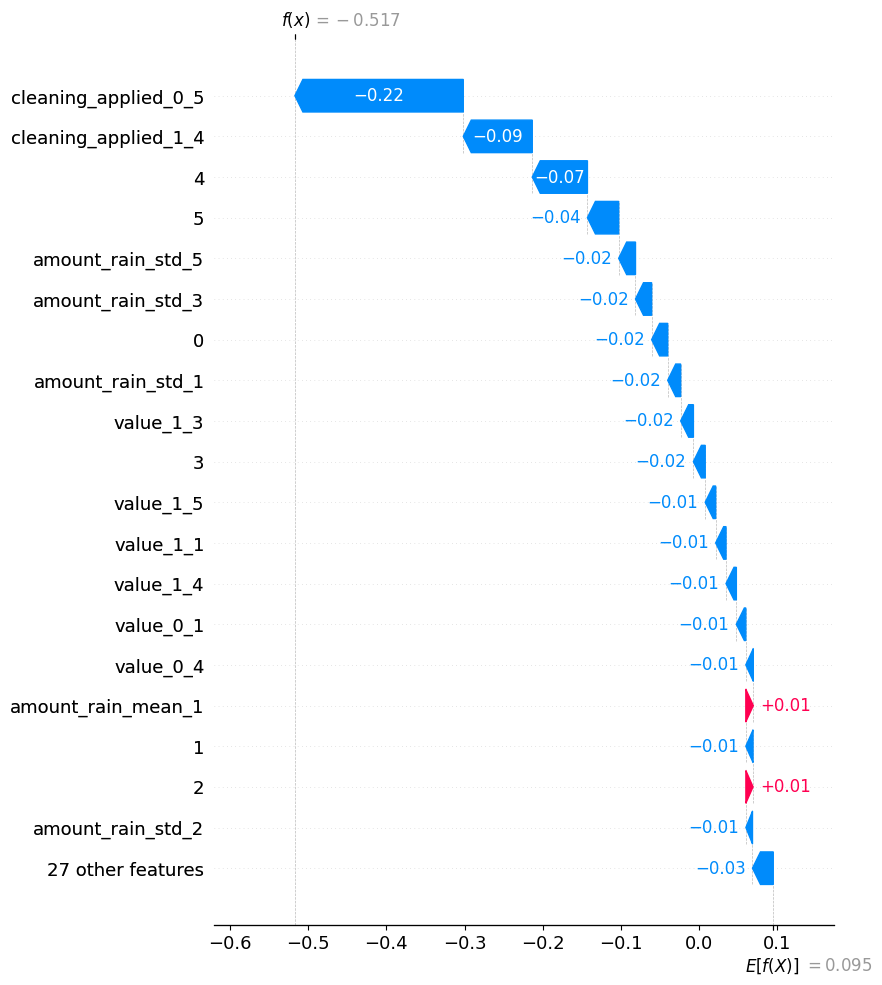

In [32]:
shap.plots.waterfall(explanation[0], max_display=20)

In [46]:
explanation.values=explanation_.values[569:570]

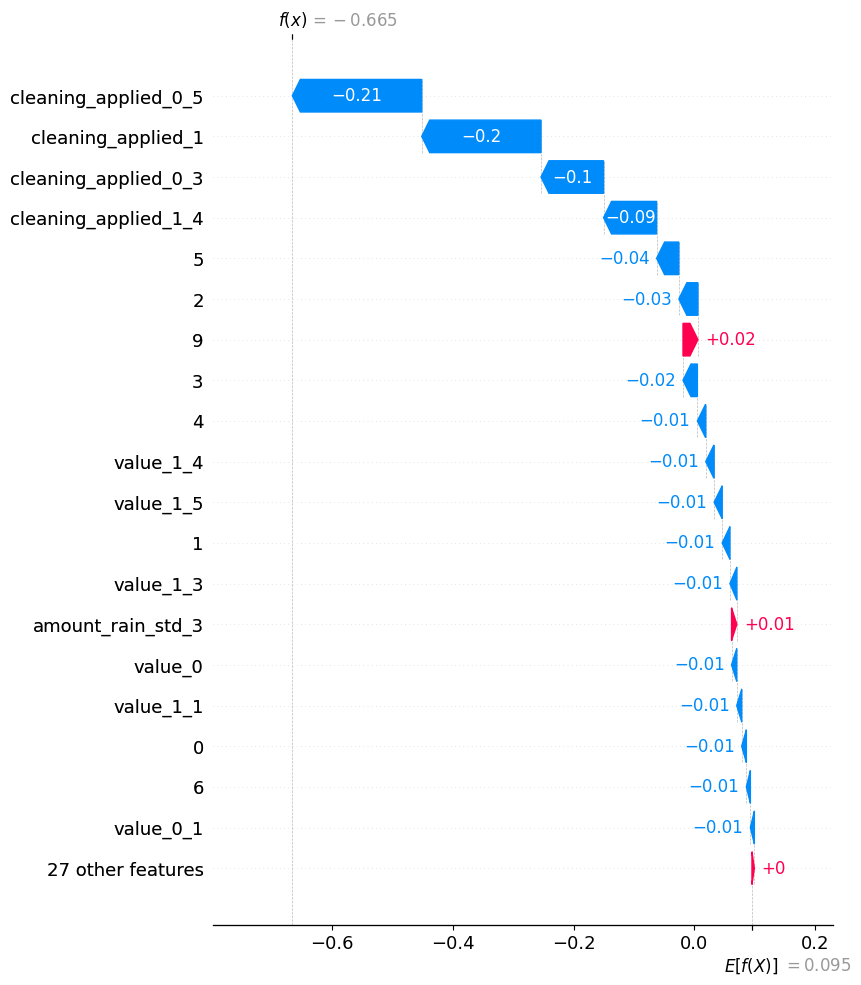

In [47]:
shap.plots.waterfall(explanation[0], max_display=20)

In [52]:
filtered_columns = [col for col in anndata.columns if 'value_0' in col]
filtered_df = anndata[filtered_columns]

<Axes: >

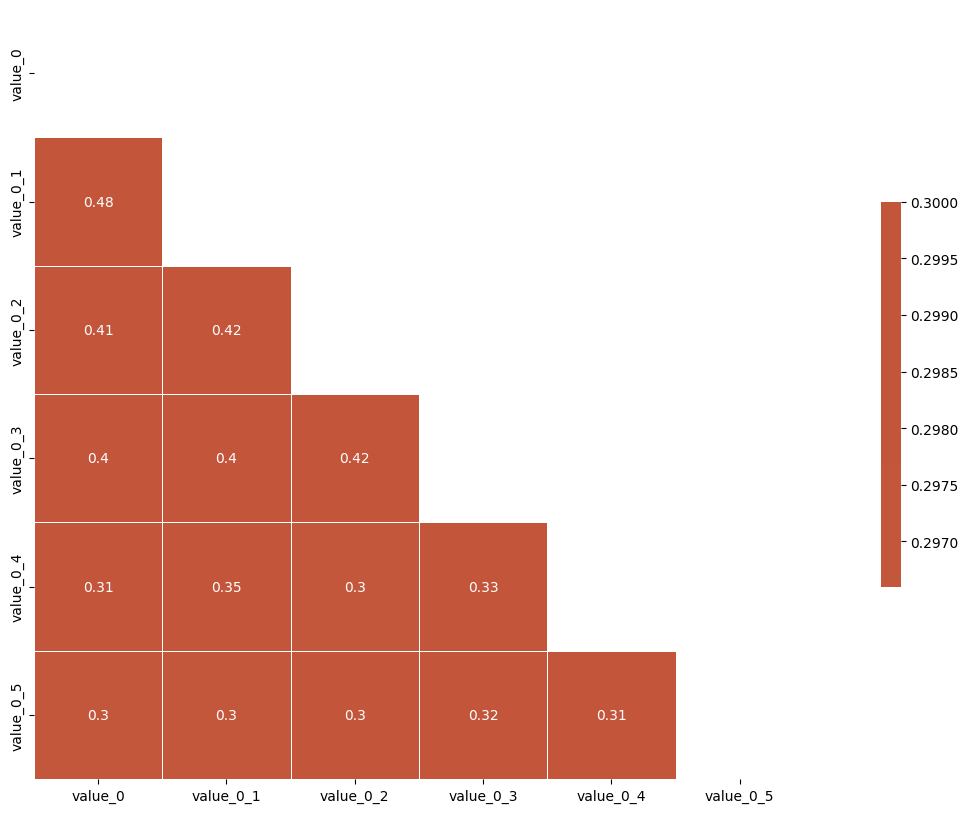

In [53]:
corr = filtered_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
filtered_columns = [col for col in anndata.columns if 'value_1' in col]
filtered_df = anndata[filtered_columns]

<Axes: >

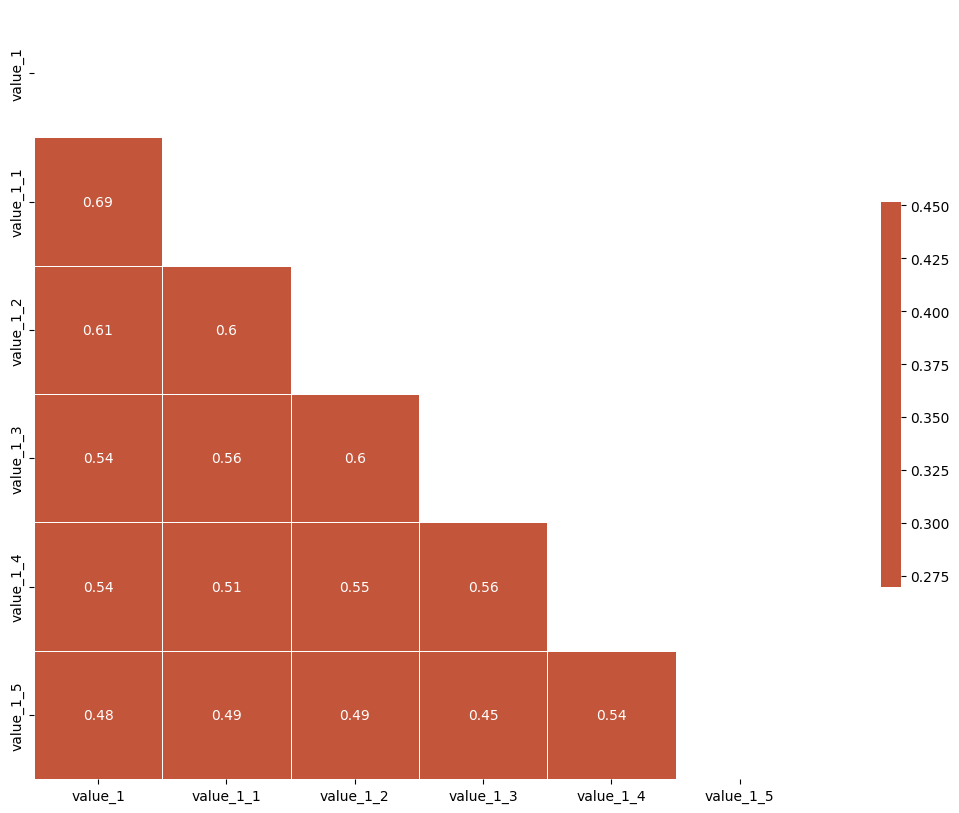

In [55]:
corr = filtered_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [69]:
filtered_columns = [col for col in anndata.columns if 'rain_m' in col]
filtered_df = anndata[filtered_columns]

<Axes: >

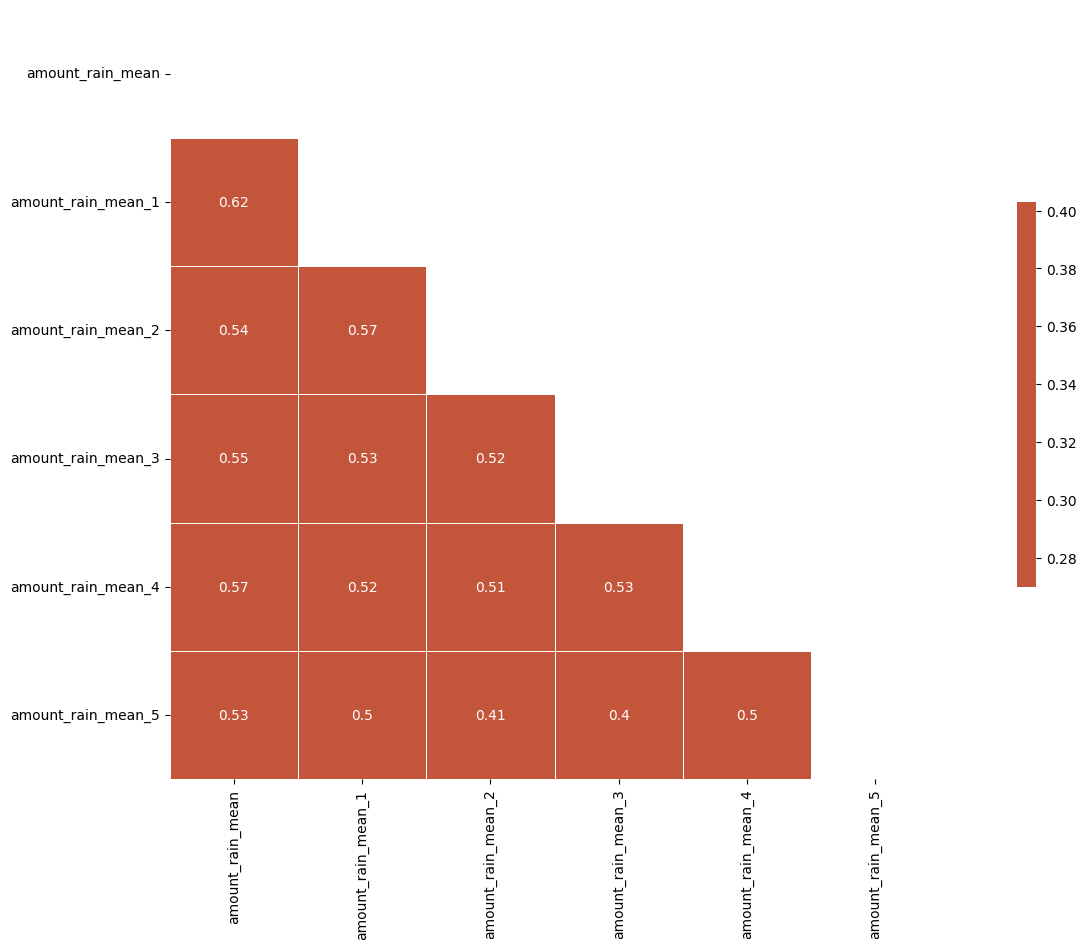

In [70]:
corr = filtered_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [71]:
filtered_columns = [col for col in anndata.columns if 'rain_s' in col]
filtered_df = anndata[filtered_columns]

<Axes: >

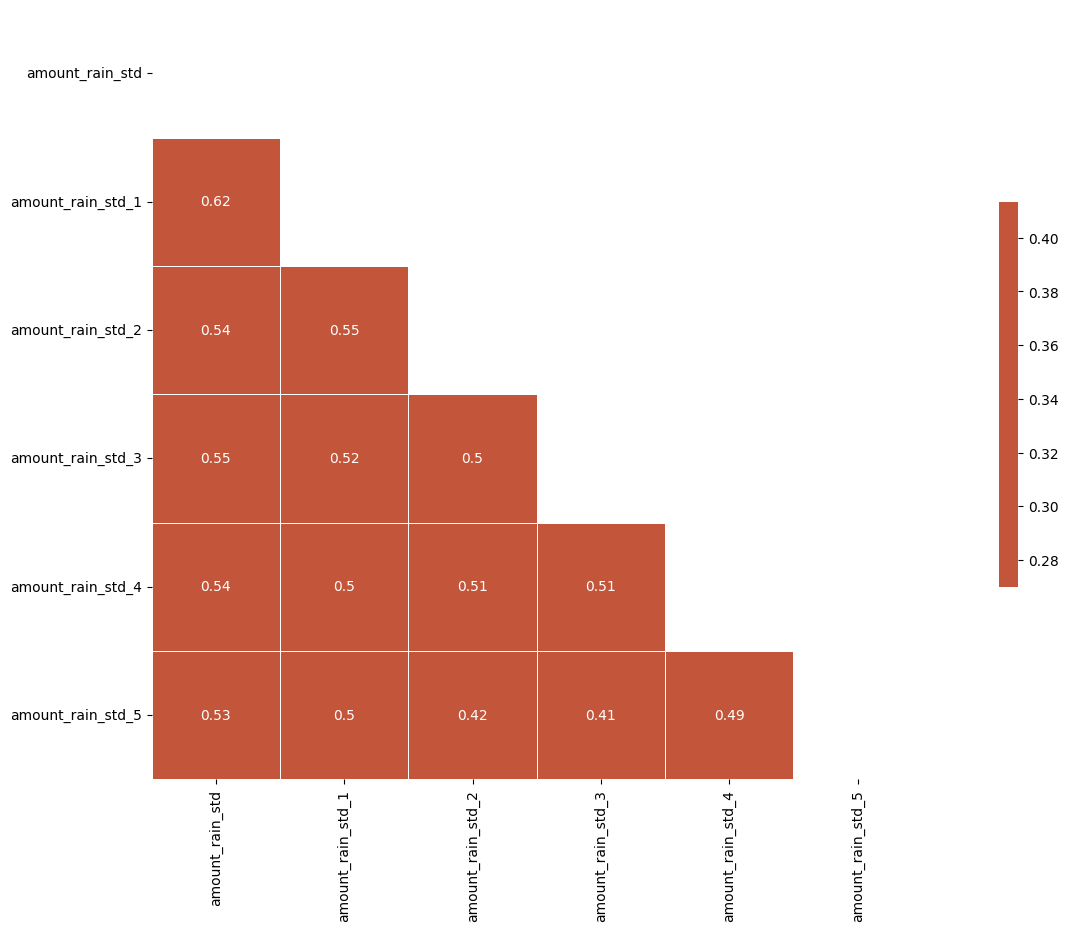

In [72]:
corr = filtered_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})